In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
import importlib
import gomokutrainer
import onnx
import keras2onnx
import matplotlib.pyplot as plt
from os import path
from datetime import datetime


In [19]:
data_raw = pd.concat([
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v3_I30000_MEC1000_05-06_10-36-25.csv", header=None, sep=';', decimal=",")
], ignore_index = True)
##Reverse first player evaluations
#print("before \n", data_raw[lambda x: x[450] == 1])
data_raw.loc[lambda x: x[675] == 1,677] = data_raw.loc[lambda x: x[675] == 1,677].apply(lambda x: x*-1)
#print("after \n", data_raw[lambda x: x[450] == 1])
input_slice = range(675)

data_train = data_raw[data_raw.index % 20 != 0].reset_index(drop = True)
data_validation = data_raw[data_raw.index % 20 == 0].reset_index(drop = True)

data_train_x = data_train[input_slice].to_numpy()
data_validation_x = data_validation[input_slice].to_numpy()

data_train_y = data_train[[677]].to_numpy()
data_validation_y = data_validation[[677]].to_numpy()

print(f"data_train_x ({len(data_train_x)}) \n", data_train_x)
print(f"data_train_y ({len(data_train_y)}) \n", data_train_y)
print(f"data_validation_x ({len(data_validation_x)}) \n", data_validation_x)
print(f"data_validation_y ({len(data_validation_y)}) \n", data_validation_y)

data_train_x (67045) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_train_y (67045) 
 [[0.05468103]
 [0.0682913 ]
 [0.07688869]
 ...
 [0.05500594]
 [0.06369221]
 [0.06854029]]
data_validation_x (3529) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_validation_y (3529) 
 [[0.05716407]
 [0.07768187]
 [0.06479082]
 ...
 [1.        ]
 [0.07401813]
 [0.10795455]]


In [20]:
#importlib.reload(gomokutrainer)
#from gomokutrainer import create_model
#model = create_model()
input_shape = (15,15,3)
input_len = input_shape[0] * input_shape[1] * input_shape[2]
"""model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(128, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(128,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )
  """

model = keras.Sequential(
  [
    keras.Input(shape=input_len, name="input"),

    layers.Reshape(input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Flatten(),

    layers.Dropout(0.5),

    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(1, activation='tanh', name="output")
  ]
)
model.compile(tf.optimizers.RMSprop(0.001), loss='mse', metrics=['mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 15, 15, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7744)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                495680    
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [21]:
history = model.fit(data_train_x, data_train_y, epochs=30, batch_size=5000, validation_data=(data_validation_x, data_validation_y))

predictions = model.predict(data_validation_x)

Epoch 1/30
14/14 [==============================] - 11s 818ms/step - loss: 0.5676 - mse: 0.5676 - val_loss: 0.2911 - val_mse: 0.2911
Epoch 2/30
14/14 [==============================] - 11s 812ms/step - loss: 0.1039 - mse: 0.1039 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 3/30
14/14 [==============================] - 11s 813ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 4/30
14/14 [==============================] - 11s 818ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 5/30
14/14 [==============================] - 11s 814ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 6/30
14/14 [==============================] - 11s 819ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 7/30
14/14 [==============================] - 12s 866ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 8/30
14/14 [==============================] - 12s 838ms/step - 

minimal validation loss = 0.00879205297678709


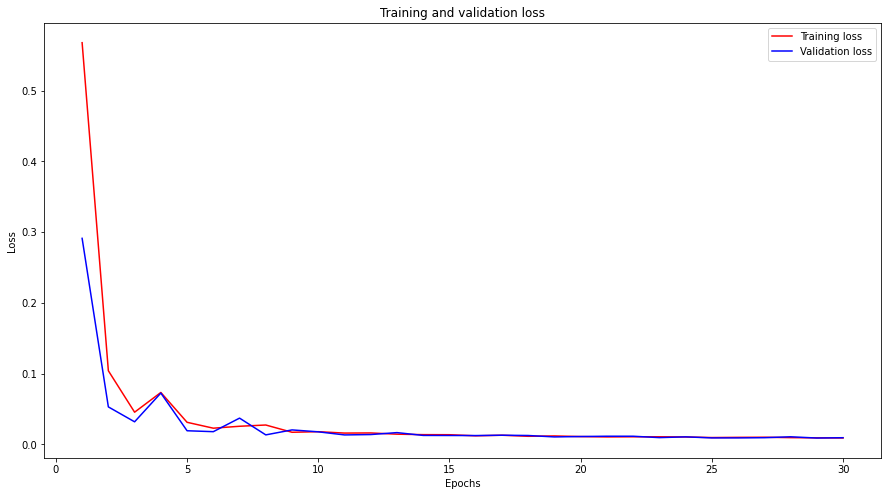

In [22]:

history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'minimal validation loss = {min(val_loss)}' )

maximal validation accuracy = 0.3527034819126129


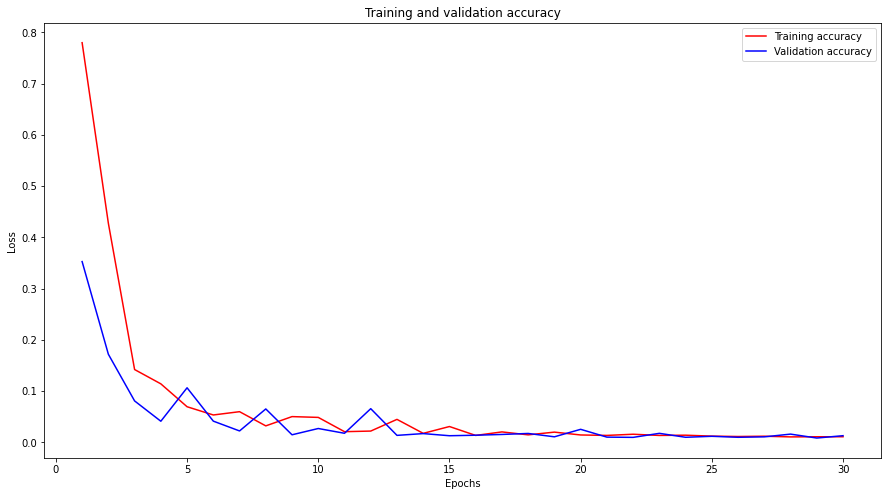

In [6]:
history.history.keys()
accuracy = history.history['mse']
val_accuracy = history.history['val_mse']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, 'r', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'maximal validation accuracy = {max(val_accuracy)}' )

In [8]:
output_path = path.join("C:\\","Projects","TrainDatasetGenerator","TrainedModels", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
model.save(path.join(output_path,"keras-model"))
onnx_model = keras2onnx.convert_keras(model, "model.onnx")
onnx.save_model(onnx_model, path.join(output_path, "model.onnx"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Projects\TrainDatasetGenerator\TrainedModels\2021-05-05_19-04-42\keras-model\assets
tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 28 -> 15
